# Obtaining Confidence Scores using BlackBox Metamodel

The Metamodel Classification  is designed to provide confidence scores for predictions made by black-box classification models using a meta-model approach. This approach follows the methodology described in Chen et al. (2019)

### Pros:
-Computational Efficiency

-Simplicity

-Versatility/Model Agnostic

-Noise Handling/Robustness

### Cons:
-Lack of Insight

-Overfitting Risk

# Mathematical Approach Behind Metamodel Classification

## Introduction

The Metamodel Classification approach involves using a base model to make predictions and a meta-model to evaluate the confidence of these predictions. This document outlines the mathematical steps involved in training and using these models.

## Base Model

Let $\mathbf{X} \in \mathbb{R}^{n \times d}$ be the input feature matrix with $n$ samples and $d$ features. The base model, $f$, is a classifier that outputs class probabilities. For a given sample $\mathbf{x}_i \in \mathbb{R}^d$, the base model provides a probability tuple $\mathbf{p}_i$, where:

$$
\mathbf{p}_i = f(\mathbf{x}_i) \in \mathbb{R}^k
$$

The predicted class label $\hat{y}_i$ is the class with the highest probability:

$$
\hat{y}_i = \arg\max_{j} \, p_{ij}
$$

## Meta-Model Training

### Feature Augmentation

For each sample $\mathbf{x}_i$, the meta-model's input features are augmented with the base model's predicted probabilities and additional features. Let $\mathbf{p}_i$ be the probability vector for sample $\mathbf{x}_i$. We augment $\mathbf{x}_i$ with the sorted probabilities and the difference between the top two probabilities:

1. **Sort Probabilities**:
   $$
   \mathbf{p}_i^{sorted} = \text{sort}(\mathbf{p}_i)
   $$

2. **Difference Between The Two Probabilities**:
   $$
   \Delta p_i = p_{i, 1} - p_{i, 0}
   $$

3. **Augmented Feature Vector**:
   $$
   \mathbf{x}_i^{meta} = [\mathbf{x}_i, \mathbf{p}_i^{sorted}, \Delta p_i]
   $$

### Meta-Model Training

The meta-model, $g$, is trained to predict whether the base model’s prediction is correct. Let $\mathbf{X}_{meta} \in \mathbb{R}^{n \times (d + k + 1)}$ be the matrix of augmented features, and $\mathbf{y}_{meta} \in \{0,1\}^n$ be the binary correctness labels. The meta-model is trained to predict $\mathbf{y}_{meta}$ based on $\mathbf{X}_{meta}$:

$$
\hat{\mathbf{y}}_{meta} = g(\mathbf{X}_{meta})
$$

where $\hat{\mathbf{y}}_{meta}$ are the predicted probabilities of the meta-model.

## Prediction with Confidence Scores

### Base Model Predictions

Given a new sample $\mathbf{x} \in \mathbb{R}^d$, the base model predicts class probabilities $\mathbf{p} = f(\mathbf{x})$ and the predicted class $\hat{y}$ is:

$$
\hat{y} = \arg\max_{j} \, p_j
$$

### Meta-Model Predictions

The features for the meta-model are created as follows:

1. **Sort Probabilities**:
   $$
   \mathbf{p}^{sorted} = \text{sort}(\mathbf{p})
   $$

2. **Difference Between Top Two Probabilities**:
   $$
   \Delta p = p_{k-1} - p_{k-2}
   $$

3. **Augmented Feature Vector**:
   $$
   \mathbf{x}^{meta} = [\mathbf{x}, \mathbf{p}^{sorted}, \Delta p]
   $$

The meta-model then provides a confidence score:

$$
\hat{z} = g(\mathbf{x}^{meta})
$$

where $\hat{z}$ is the probability assigned by the meta-model that the base model's prediction is correct.

## Conclusion

The Metamodel Classification approach uses a base model to make predictions and a meta-model to estimate the confidence of these predictions. The meta-model is trained with augmented features from the base model's output and assesses the correctness of the base model's predictions.


### Step 1: Write Import Statements

In [12]:
from uq360.algorithms.blackbox_metamodel import MetamodelClassification
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np

### Step 2: Load and pre-process Dataset

In [13]:
df=pd.read_csv("customer_purchase_data.csv")
X = df[['Age', 'Gender','AnnualIncome','NumberOfPurchases','ProductCategory','TimeSpentOnWebsite','LoyaltyProgram','DiscountsAvailed']]
y = df['PurchaseStatus']
df.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


### Step 3: Train GBM Model

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_train_base, X_train_meta, y_train_base, y_train_meta = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

In [14]:
gbm = GradientBoostingClassifier()
_=gbm.fit(X_train_base, y_train_base)

### Step 4: Add Uncertainty model to externally trained GBM model

In [5]:
meta_config = {'n_estimators': 150, 
               'max_depth': 2,
               'learning_rate': 0.1, 
               'min_samples_leaf': 10, 
               'min_samples_split': 10,
               'random_state': 42}

In [6]:
meta_mdl = GradientBoostingClassifier(**meta_config)
uq_model = MetamodelClassification(base_model=gbm, meta_model=meta_mdl, 
                             base_config=None, meta_config=meta_config)
_=uq_model.fit(X=None, y=None, base_is_prefitted=True, meta_train_data=(X_train_meta, y_train_meta))

### Step 5: Obtain prediction and associated Confidence Score

In [15]:
_, y_test_score = uq_model.predict(X_test)
y_test_pred=gbm.predict_proba(X_test)[:,1]
data = {
    'Predicted GBM': y_test_pred,
    'MetaModel Confidence Score': y_test_score,
    'Target Class': y_test
}
df = pd.DataFrame(data)
pd.set_option('display.max_rows', None)
print(df)

      Predicted GBM  MetaModel Confidence Score  Target Class
1116       0.911723                    0.921337             1
1368       0.008668                    0.981183             0
422        0.047726                    0.930589             0
413        0.040323                    0.923123             0
451        0.991082                    0.944253             1
861        0.006503                    0.952608             0
1063       0.982739                    0.960878             1
741        0.077270                    0.920322             0
1272       0.028272                    0.936957             0
259        0.055537                    0.970014             0
888        0.962631                    0.891968             1
1432       0.813928                    0.989539             1
712        0.078756                    0.966688             0
1382       0.029277                    0.973476             0
70         0.943302                    0.926165             1
1268    

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the Gradient Boosting Classifier:", accuracy)

Accuracy of the Gradient Boosting Classifier: 0.9066666666666666


### Step 6: Assess UQ Quality

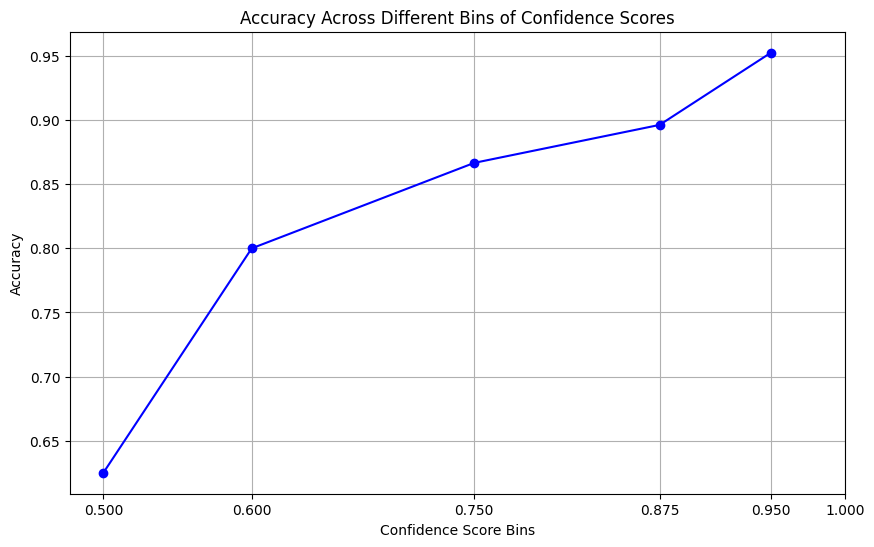

In [9]:
bins=[0.5, 0.6,0.75,0.875 ,0.95,1.0]
bin_indices = np.digitize(y_test_score, bins) - 1

accuracies = []
for i in range(len(bins) - 1):
    bin_mask = bin_indices == i
    if np.any(bin_mask):
        accuracy = accuracy_score(y_test[bin_mask], gbm.predict(X_test[bin_mask]))
    else:
        accuracy = np.nan
    accuracies.append(accuracy)
    
plt.figure(figsize=(10, 6))
plt.plot(bins[:-1], accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Confidence Score Bins')
plt.ylabel('Accuracy')
plt.title('Accuracy Across Different Bins of Confidence Scores')
plt.xticks(bins)
plt.grid(True)
plt.show()

#### As we can see, the higher the confidence score the most accurate the prediction is based on accuracy

## Combining Prediction and Confidence Score to Obtain Better Estimates

In [10]:
loaded_params = np.load('model_parameters.npz')
loaded_coefficients = loaded_params['coefficients']
loaded_intercept = loaded_params['intercept']

def logistic_function(z):
    return 1 / (1 + np.exp(-z))

def predict(X, coefficients, intercept):
    z = np.dot(X, coefficients.T) + intercept
    probabilities = logistic_function(z)
    return probabilities

### Ranking prediction based on Combined Score

In [11]:
y_pred_not_used, y_test_score = uq_model.predict(X_test)
y_test_pred=gbm.predict_proba(X_test)[:,1]
X_new=np.column_stack((y_test_pred, y_test_score))
new_score = predict(X_new, loaded_coefficients, loaded_intercept)
new_score=[i[0] for i in new_score]
data = {
    'Predicted GBM': y_test_pred,
    'GBM Confidence Score': y_test_score,
    'Combined Score': new_score,
    'Target Class': y_test
}
df = pd.DataFrame(data)
df= df.sort_values(by='Combined Score', ascending=False)
pd.set_option('display.max_rows', None)
print(df)
sorted_y_test_2 = df['Target Class'].values

      Predicted GBM  GBM Confidence Score  Combined Score  Target Class
1125       0.996527              0.983493        0.939286             1
1249       0.994256              0.933614        0.938927             1
736        0.994762              0.988320        0.938743             1
44         0.992692              0.958294        0.938319             1
451        0.991082              0.944253        0.937930             1
1424       0.986551              0.786252        0.937560             1
1491       0.989415              0.938059        0.937474             1
275        0.989893              0.966256        0.937441             1
287        0.990013              0.991476        0.937321             0
324        0.989725              0.984207        0.937280             1
1169       0.987262              0.886606        0.937150             1
534        0.988932              0.978098        0.937081             1
970        0.988492              0.972669        0.936983       

#### A perfect order would separate flawlessly 1's from 0's

## References

1. Chen, Tongfei, et al. (2019 ). "Confidence scoring using whitebox meta-models with linear classifier probes.",
    The 22nd International Conference on Artificial Intelligence and Statistics.